# Probe positions and affine transformation in fold slice (PtychoShelves fork)

This notebook is compiled to keep notes on relavent bits about position correction and affine transformtaion in fold slice (PtychoShelves fork).
- Author: Chia-Hao Lee, cl2696@cornell.edu
- Date: 20260213

## 00. Introduction
Probe positions are critical for high-quality ptychographic reconstruction, because both electron and X-ray ptychography suffer from imperfect scan systems and sample drifts.

Most ptychography packages provide "position correction" feature, which allows the reconstruction algorithm to also refine the probe position.

However, most position correction implementations only handle small random shifts, and cannot fully correct the global scan distortions.

These global scan distortions are mostly coming from (1) inaccurate scan system calibration and (2) dataset-dependent sample drift,

and can be defined as an **2x2 affine transformaiton matrix** A, where `pos_model = A @ pos_0`, `pos_0` is the original position, and `pos_model` is the affine-transformed position.

For readbility, we often **decompose the 2x2 affine matrix into 4 scalar affine components (scale, asymmetry, rotation, shear)**.

> **Note**: different packages often have different sign conventions of their coordinate system, different definitions of affine components, and rotation/shear could be in unit of radian or degree. For example, PtyShv often requires a custom scan flip of [1,1,0] to align scan direction with STEM convention, which flips the sign of rotation and shear with respect to PtyRAD due to y-axis flipping. So PtyRAD with +3 deg rotation, no scan flipping becomes -3 deg rotation and [1,1,0] scan flipping in PtyShv.

## 01. How dose fold slice perform position correction with affine constraint?

*fold_slice* (20241123 commit: d9a1204) provides a couple settings to configure affine transformation and position correction behavior:

```matlab
p.   affine_matrix = compose_affine_matrix(scan_affine(1), ...
                     scan_affine(2), scan_affine(3), scan_affine(4)); 
                     % Applies affine transformation (e.g. rotation, stretching) to the positions (ignore by = []). Convention [yn;xn] = M*[y;x].

eng. apply_subpix_shift = true;                         % apply FFT-based subpixel shift, it is automatically allowed for position refinement
eng. probe_position_search = 1;                         % iteration number from which the engine will reconstruct probe positions
eng. probe_geometry_model = {'scale', 'asymmetry', ...
                            'rotation', 'shear'};       % {}, the geometry model, choose from: {'scale', 'asymmetry', 'rotation', 'shear'}
eng. probe_position_error_max = inf;                    % maximal expected random position errors, probe prositions are confined in a circle
eng. apply_relaxed_position_constraint = true;          % added by YJ. Apply a relaxed constraint to probe positions. default = true. 
eng. update_pos_weight_every = 100;                     % added by YJ. Allow position weight to be updated multiple times. default = inf: only update once.
```
See [`ptyshv_solver.m`](https://github.com/chiahao3/fold_slice_work/blob/main/scripts/ptyshv_utils/ptyshv_solver.m) (my fold slice wrapper) for reference.

**During initialization**, `p.   affine_matrix` is the affine correction applied on raw position. `pos_init = affine_matrix @ pos_raw`. 
  - Both `pos_init` and `affine_matrix` are tracked and saved, while `pos_raw` is NOT saved or used once pass the stage of initialization.

**At the end of each iteration**, `eng. apply_relaxed_position_constraint` is the main control of whether a geometry model (defined by affine components) is applied to "constrain / regularize" probe positions.
  - See [`find_geom_correction.m`](https://github.com/yijiang1/fold_slice/blob/d9a1204b9d43a6f34c6f10cc5549f3606fa3f396/ptycho/%2Bengines/%2BGPU_MS/%2Bshared/find_geom_correction.m) for implementation details. This feature contains some sophisticated design of how to calculate the weights for soft constraints (so random shifts are partially conserved).
  - Although this switch is by default `true` (internally), however, the example scripts on *fold_slice* repo have explictly set it to both `true` (MoSe2) and `false` (PSO).
  - If set to `true`, the output folder looks like "/MLs_L1_p8_g64_pc50_**scale_asym_rot_shear**_updW100_Ns21_dz10_reg1_dpBlur1_dpFlip_T"
  - If set to `false`, the output folder looks like "/MLs_L1_p8_g64_pc50_**noModel**_updW100_Ns21_dz10_reg1_dpBlur1_dpFlip_T"
  - This constraint is tested to be useful in certain mis-calibration cases (i.e., scan rotation), and might also be useful for shear, but it doesn't seem to help for the case of global scaling error.

## 02. Overall Suggestions
- Position correction is always needed for high-quality reconstruction on experimental data with drifts and imperfect scan system / calibration
- Proper calibration of scan step size and detector rotation on EACH MICROSCOPE is strongly recommended
- Acquire experimental data AFTER the drift is settled (as much as possible) so the actual scan pattern is closer to the calibrated scan step size
- Keep your scan step size fixed with UI magnification for clarity, and use affine matrix to account for dataset-dependent distortions for individual reconstructions 
- Use vBF or rough ptycho reconstructions to extract an initial guess of affine matrix. See [this interactive notebook](https://ptyrad.readthedocs.io/en/latest/workflow/get_affine_from_image.html) for example. 
- While applying affine corrections, keep track of the **reference of the affine matrix**, i.e., is the obtained affine matrix acting on the original position, or the reconstructed positions.

## 03. Actual fold slice example with numbers

- dataset: PSO
- Npix: 128 (raw data at 128, publicly available dataset was padded to 256. I crop it back to 128 for efficiency)
- N_scan_x, N_scan_y: 64, 64
- scan step size: 0.41 Ang
- scan affine (affine components of scale, asymmetry, rotation, shear): [1.1, 0, 0, 0] # scale = 1.1, or 10% overestimate of scan step size
- probe_geometry_model: ["scale", "asymmetry", "rotation", "shear"]
- apply_relaxed_position_constraint: true
- update_pos_weight_every: 100
- NITER: 600

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Set this to your desired working directory so you can easily access the data, model, param files
work_dir = "H:/workspace/fold_slice_work/"

os.chdir(work_dir)
print("Current working dir: ", os.getcwd())
# Note that the output/ directory will be automatically generated under your working directory

Current working dir:  H:\workspace\fold_slice_work


In [2]:
from ptyrad.load import load_mat # using ptyrad v0.1.0b12
mat = load_mat('output/PSO/20260212_affine_1.1_0_0_0/roi1_Ndp128_step64/MLs_L1_p8_g64_pc50_scale_asym_rot_shear_updW100_Ns21_dz10_reg1_dpBlur1_dpFlip_T/Niter600.mat')

Detected .mat v7.3 (HDF5 format). Delegating to `load_hdf5`.
Detected data.shape = (21, 336, 336) with data.dtype = [('real', '<f8'), ('imag', '<f8')]. Casting back to 'complex128'.
Detected data.shape = (8, 128, 128) with data.dtype = [('real', '<f8'), ('imag', '<f8')]. Casting back to 'complex128'.
Success! Loaded .hdf5 file as a dict from path = 'output/PSO/20260212_affine_1.1_0_0_0/roi1_Ndp128_step64/MLs_L1_p8_g64_pc50_scale_asym_rot_shear_updW100_Ns21_dz10_reg1_dpBlur1_dpFlip_T/Niter600.mat'


In [3]:
mat.keys() # ignore the keys with #, typical accessible entries are 'object', 'outputs', 'p', 'probe'

dict_keys(['#refs#', '#subsystem#', 'object', 'outputs', 'p', 'probe'])

In [4]:
mat['outputs'].keys()

dict_keys(['Np_o', 'Np_p', 'Npos', 'affine_matrix', 'affine_matrix_fit', 'affine_matrix_init', 'asymmetry', 'avgTimePerIter', 'background', 'detector_rotation', 'detector_scale', 'diff_pattern_blur', 'diffraction', 'diffraction_deform_matrix', 'filename', 'fourier_error_dp', 'fourier_error_out', 'fourier_error_threshold', 'intensity_corr', 'lambda', 'mask', 'modes', 'noise', 'object', 'path', 'pixel_size', 'probe', 'probe_evolution', 'probe_fourier_shift', 'probe_positions', 'probe_positions_0', 'probe_positions_model', 'probe_positions_weight', 'probe_support', 'probe_support_fft', 'reconstruct_ind', 'relative_pixel_scale', 'rotation', 'shear', 'z_distance'])

In [5]:
mat['p'].keys()

# `mat['p']['dx_spec']` and `mat['outputs']['pixel_size']` are the same, they're duplicated entries

dict_keys(['binning', 'detector', 'dx_spec', 'init_probe_file', 'lambda', 'multi_slice_param', 'normalize_init_probe', 'obj_init_param', 'object_ROI'])

In [6]:
# Parse dicts and variables
probe_change_start = 50 # This was set in reconstruction script but wasn't stored in output .mat
outputs = mat['outputs']

# Affine matrix (2x2 matrix)
# `affine_matrix` and `affine_matrix_fit` are equal within numerical precision, 
# if `eng. probe_geometry_model` contains the full degree of freedom of 4 affine components and `eng. apply_relaxed_position_constraint = true`. 
# See Line 122 to Line 139 in `find_geom_correction.m` for implementation details
affine_matrix = outputs['affine_matrix']           # Fitted from "initialized position" to "reconstructed position" at each iteration with **user-specified affine components** (can be 1 to 4 components)
affine_matrix_fit = outputs['affine_matrix_fit']   # Fitted from "initialized position" to "reconstructed position" at each iteration with **all 4 affine components**
affine_matrix_init = outputs['affine_matrix_init'] # Used to create "initialized position" from "raw position". `pos_init = affine_matrix_init @ pos_raw`. This is the same `p. affine_matrix` specified by user.

# Affine components
scale = outputs['relative_pixel_scale'].squeeze() # The PtyShv naming is confusing, but it's indeed the scaling of "scan step size". See Line 787 at fold_slice\ptycho\+engines\+GPU_MS\ptycho_solver.m.
asymmetry = outputs['asymmetry'].squeeze()
rotation = outputs['rotation'].squeeze()
shear = outputs['shear'].squeeze()

# Probe positions
probe_positions = outputs['probe_positions']               # (2,N) Reconstructed position in px at current iteration
probe_positions_0 = outputs['probe_positions_0']           # (2,N) Initialzied position in px, which is fixed throughout the reconstruction
probe_positions_model = outputs['probe_positions_model']   # (2,N) Affine modeled position, affine_matrix @ probe_positions_0
probe_positions_weight = outputs['probe_positions_weight'] # (2,N) Position-dependent weights in x, y direction used for linearly mixing the reconstructed positions with affine modeled positions

# Pixel size
pixel_size = outputs['pixel_size'][0] # Ang, determined by kMax and calculated from convergence angle and RBF

In [7]:
affine_matrix

array([[0.99449057, 0.01641187],
       [0.03283493, 0.9840263 ]])

In [8]:
affine_matrix_fit # float is accurate to 6 decimals

array([[0.9944903 , 0.01641175],
       [0.03283516, 0.98402654]])

In [9]:
affine_matrix_init # This is the same `p. affine_matrix` specified by user. 
# So user-specified `p. affine_matrix` (used during initialization) ends up becoming `outputs['affine_matrix_init']`
# while during reconstruction, the additionally fitted affine matrix becomes `outputs['affine_matrix]`, 
# which is applied on top of the initialized position, hence on top of `p. affine_matrix`. 

array([[1.1, 0. ],
       [0. , 1.1]])

### Notes
- `affine_matrix_init` is used to prepare `pos_init`, and `pos_init = affine_matrix_init @ pos_raw`
- `affine_matrix` is used to fit (approximate) `pos_reconstruct` with `pos_model` with respect to `pos_init`, so `pos_reconstruct ~ pos_model = affine_matrix @ pos_init`
- Note that these two affine matrices are applied on **DIFFERENT reference positions**
  - At each iteration, `pos_model = affine_matrix @ pos_init = affine_matrix @ (affine_matrix_init @ pos_raw)`.

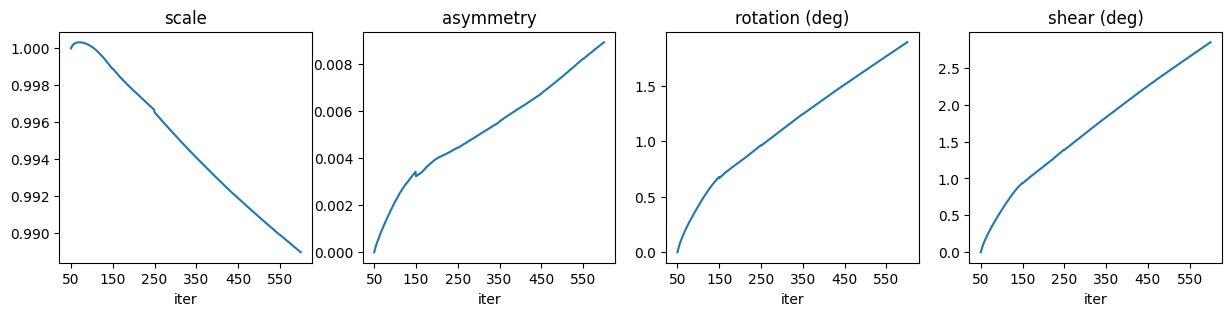

In [10]:
# This is the typical PtyShv output figure of the evolution of affine components fitted from "initialized position" to "reconstructed position" at each iteration
# These plots essentially track the progress of position correction (from initialzed position to reconstructed position)
# Although the scan pattern was intentionally enlarged by 10% (scale=1.1), 600 iterations only correct ~ 1% from the initialized probe positions

titles = ['scale', 'asymmetry', 'rotation (deg)', 'shear (deg)']
fig, axs = plt.subplots(1,4, figsize=(15,3))
for i, affine_component in enumerate([scale, asymmetry, rotation, shear]):
    axs[i].set_title(titles[i])
    axs[i].plot(np.arange(probe_change_start, probe_change_start + len(affine_component)), affine_component)
    axs[i].set_xlabel('iter')
    axs[i].set_xticks(np.arange(50, 600+1, step=100))
plt.show()

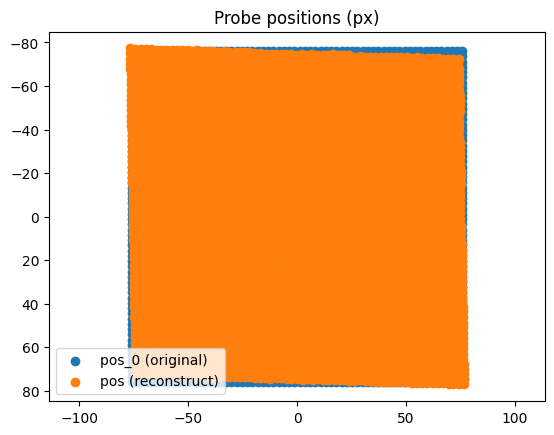

In [11]:
# probe_position
pos_0 = probe_positions_0.T # (N,2)
pos = probe_positions.T # (N,2)
plt.figure()
plt.title("Probe positions (px)")
plt.scatter(x=pos_0[:,0], y=pos_0[:,1], c='C0', label='pos_0 (original)')
plt.scatter(x=pos[:,0], y=pos[:,1], c='C1', label='pos (reconstruct)')
plt.legend()
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

`find_geom_correction.m`

```matlab
if par.apply_relaxed_position_constraint 
    %% apply only relaxed constrain on the probe positions  !!! 
    relax = 0.1;
    % constrain more the probes in flat regions 
    W = relax*(1-  (probe_positions_weight./ (1+probe_positions_weight)));  
    % penalize positions that are further than max_err from origin 
    W = min(10*relax, W+max(0,err - max_err).^2 ./ max_err.^2  );  % avoid travel larger than max error
else
    W=0; %no geom model imposed to regularize positions
end

% allow free movement in depenence on realibility and max allowed error 
pos_new =  pos .*(1-W)+W.*pos_model; 
```

> **Note**: W = relax*(1 / (1+weight)), so smaller weight gives larger W, and larger W means stronger contribution from pos_model.


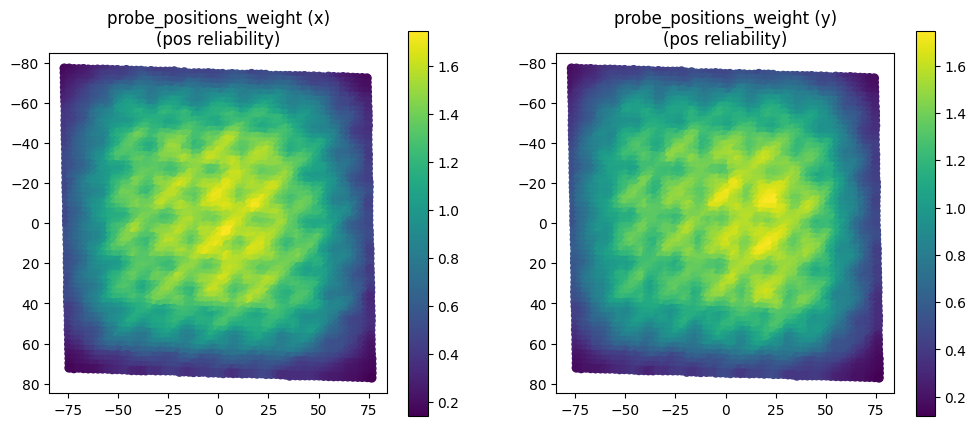

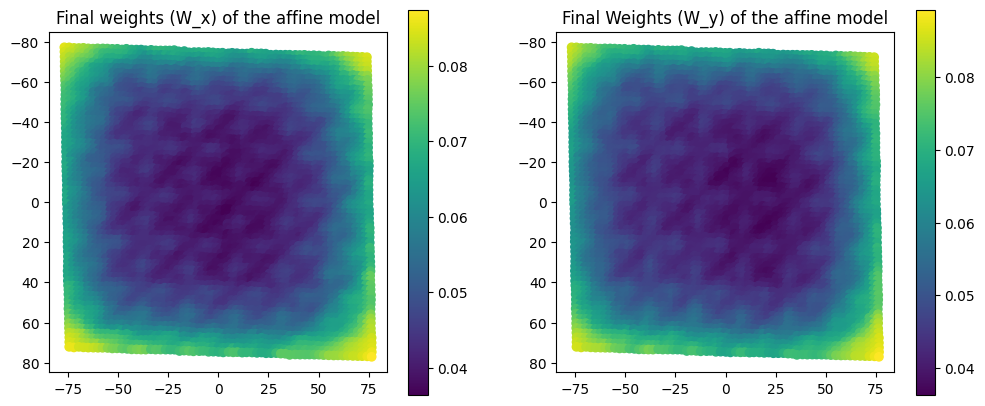

In [12]:
# probe_positions_weight, higher weights means the final positions contain less contribution from pos_model

# Note that weight ranges from 0.17 (edge) to 1.7 (center) in this cases, hence W = 0.1*1/(1+0.17) = 8.5% at the corner, but W = 3.7% at the center.

# Overall speaking, the regularization power from affine modeling is relatively weak.

pos = probe_positions.T # (N,2)
weights = probe_positions_weight.T # (N,2), this is essentially illumination-weighted local object contrast, higher object contrast means position is more reliable.
W = 0.1*(1 - (weights/(1+weights)))
W = W.clip(max=1) #essentially clips at 1 when max_err is inf.

fig, axs = plt.subplots(1,2, figsize=(12,5))
p0 = axs[0].scatter(x=pos[:,0], y=pos[:,1], c=weights[:,0])
p1 = axs[1].scatter(x=pos[:,0], y=pos[:,1], c=weights[:,1])
axs[0].set_title('probe_positions_weight (x)\n(pos reliability)')
axs[1].set_title('probe_positions_weight (y)\n(pos reliability)')
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
fig.colorbar(p0)
fig.colorbar(p1)
axs[0].invert_yaxis()
axs[1].invert_yaxis()
plt.show()

fig, axs = plt.subplots(1,2, figsize=(12,5))
p0 = axs[0].scatter(x=pos[:,0], y=pos[:,1], c=W[:,0])
p1 = axs[1].scatter(x=pos[:,0], y=pos[:,1], c=W[:,1])
axs[0].set_title('Final weights (W_x) of the affine model')
axs[1].set_title('Final Weights (W_y) of the affine model')
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
fig.colorbar(p0)
fig.colorbar(p1)
axs[0].invert_yaxis()
axs[1].invert_yaxis()
plt.show()

In [13]:
# Sanity check of `probe_positions_0`
pos_0[:2]

array([[-76.        , -76.        ],
       [-73.59071617, -76.        ]])

In [14]:
(pos_0[:2,0] - pos_0[:2,1]) * pixel_size # Ang
# Note that 0.451 Ang is essentially 0.41 * 1.1, or scan_step_size * scale
# So the probe_positions_0 used for affine model fitting is indeed the initialized position
# and such initialiazed position is generated by combining user-assigned affine matrix with pos_raw

array([0.   , 0.451])

## 04. How to read the PtyShv log output

ref: log_job_59525_ptyshv_PSO.txt

```text
[GPU-1_MLs_PSO] : ========= 2D PTYCHO GEOMETRY REFINEMENT, apply manually to your template ===========
[GPU-1_MLs_PSO] : p.affine_matrix =  [1.082 , 0.03612 ; 0.01805 , 1.094 ] 
[GPU-1_MLs_PSO] : ====================================================================================
[GPU-1_MLs_PSO] : 
[GPU-1_MLs_PSO] : Advanced: ======================== AFFINE CORRECTION OF SCANNER AXIS ====================
[GPU-1_MLs_PSO] : Advanced: (for control system of piezo scanner, important for calibration of cSAXS fast FZP scanner)
[GPU-1_MLs_PSO] : Advanced: correction_matrix = inv(p.affine_matrix) =  [0.9244 , -0.03052 ; -0.01525 , 0.9146 ]  
[GPU-1_MLs_PSO] : Advanced: ===============================================================================
[GPU-1_MLs_PSO] : Note:  Use scans at 0 and 180 deg with eng.share_object == true && eng.mirror_objects == true to get estimation of the 0vs180deg affine matrix requied for ptychotomography
[GPU-1_MLs_PSO] : 
[GPU-1_MLs_PSO] : 
[GPU-1_MLs_PSO] : ==== Geometry parameters for each scan===== 
[GPU-1_MLs_PSO] : Scan #1: [scale=1.0879 , asymmetry=-0.012 , rotation=1.914deg , shear=2.858deg, shift = 0.0 0.0px ] 
```

This summary is generated via `fold_slice\ptycho\+engines\+GPU_MS\+analysis\report_refined_geometry.m`

Line 88 - 140 basically says the **reported (suggested) affine matrix = model fitted affine matrix @ user-specified affine matrix**.

```matlab
for ii = 1:length(self.affine_matrix)
    p.affine_matrix_refined{ii} = p.affine_matrix * self.affine_matrix{ii};
end

...

median_affine_matrix = median(cat(3,p.affine_matrix_refined{:}),3);

...

verbose(0, '========= 2D PTYCHO GEOMETRY REFINEMENT, apply manually to your template ===========')
verbose(0, 'p.affine_matrix = %s' , mat2str(median_affine_matrix))

...

for ii = 1:length(p.affine_matrix_refined)
    [scale, asymmetry, rotation, shear] = math.decompose_affine_matrix(p.affine_matrix_refined{ii}); 
    verbose(0, 'Scan #%i: [scale=%.4f , asymmetry=%.3f , rotation=%.3fdeg , shear=%.3fdeg, shift = %.1f %.1fpx ] ', [p.scan_number(ii), scale, asymmetry, rotation, shear, self.shift_scans(:,ii)'])
end  
```

- In the case where there's no user-specified affine matrix `p. affine_matrix = []`, the output affine matrix essentially maps the initialized position to the reconstructed position (~ model position). This is equivalent to load the reconstructed position and start a new run.

- In the case where user-specified affine matrix is not identity (i.e., `p. affine_matrix = [1.1, 0; 0, 1.1]`), the output affine matrix (`p. affine_matrix = [1.082 , 0.03612 ; 0.01805 , 1.094 ]`) is used to replaced the originally specified value (`[1.1, 0; 0, 1.1]`) so it can be mapped to the reconstructed position, and the difference between `[1.1, 0; 0, 1.1]` and `1.082 , 0.03612 ; 0.01805 , 1.094]` is exactly the effect of 600 iterations, which is arguably negligible, suggesting that `eng. apply_relaxed_position_constraint` and position correction can not correct the mis-calibration of scan step size in an effective way.

In sum, the reported `p. affine_matrix` from PtyShv log is essentially **the summarized effect of position correction** (fitted from initialized position to reconstructed position) **multiplied by the user-specified affine matrix** (usually identity matrix).

In [15]:
affine_matrix_init # This is user-specified affine transformation for initialization

array([[1.1, 0. ],
       [0. , 1.1]])

In [16]:
affine_matrix # This is the effect from 600 iterations

array([[0.99449057, 0.01641187],
       [0.03283493, 0.9840263 ]])

In [17]:
affine_matrix @ affine_matrix_init # This is the PtyShv suggested value if you want to map to the "reconstructed" position, which is really not that much better than our affine_matrix_init
# Note that there's a 180-deg rotation involved (x -> -x, y -> -y) because PtyShv is internally converting back and forth between probe and stage positions

array([[1.09393963, 0.01805305],
       [0.03611842, 1.08242893]])